In [1]:
import numpy as np 
from scipy.io import loadmat
import matplotlib.pyplot as plt
import os
import re
import numpy as np
from datetime import datetime
import netCDF4 as nc
import torch.nn as nn
import torch
import tqdm
import copy
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
import scipy 
import glob
import cartopy.crs as ccrs
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import scipy
from sklearn.linear_model import LinearRegression

 
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
from sklearn.gaussian_process.kernels import ConstantKernel as C, RBF, WhiteKernel, Matern
import itertools
from sklearn.ensemble import BaggingRegressor
import matplotlib.pyplot as plt
import torch.optim as optim
import matplotlib.gridspec as gridspec



In [3]:
import random 

# Set all seeds FIRST
def set_seeds(seed=57):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.cuda.manual_seed_all(57)

set_seeds(57)
import numpy as np
np.random.seed(57)

In [4]:
def restructuring_filtered_array(filtered_values,boolean_mask,rows,cols):
    reconstructed_array = np.full((rows, cols), np.nan)
    flat_array = reconstructed_array.flatten()
    flat_array[boolean_mask] = filtered_values
    reconstructed_array = flat_array.reshape((rows, cols))
    return reconstructed_array


def circshift(arr, shifts):
    """
    Circular shift like MATLAB's circshift
    shifts: list/tuple of shifts for each dimension
    """
    result = arr
    for axis, shift_val in enumerate(shifts):
        if shift_val != 0:
            result = np.roll(result, shift_val, axis=axis)
    return result


In [5]:
ms = scipy.io.loadmat('MatlabStarter (1).mat')




In [6]:
# How many days do you want to run (starts Jan 1)
nday = 365
year_pick = 2010
startstring = 'astronaut' # Prefix for saved 
max_hours = 24

In [8]:
locations = pd.read_csv('Locations_File.csv')

In [9]:


i1 = ms['i1'][0][0]
i2 = ms['i2'][0][0]
i3 = ms['i3'][0][0]
i4 = ms['i4'][0][0]





# Projection
projection = ccrs.Stereographic(
    central_latitude=-90,
    false_easting=0.0,
    false_northing=0.0,
    true_scale_latitude=-71.0,
    globe=ccrs.Globe('WGS84'))

In [10]:


torch.manual_seed(57)

model = torch.nn.Sequential(
    torch.nn.Linear(18, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64,64),
    torch.nn.ReLU(),
    torch.nn.Linear(64,64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1),
    torch.nn.ReLU(),
    
)
torch.manual_seed(57)

proper_indices = []

lat_locs = locations['latitude']
lon_locs = locations['longitude']

for locx,location in enumerate(locations['site_name'].to_numpy()):
    # zeepoint =projection.transform_points(ccrs.PlateCarree(),np.asarray(lon_locs[locx]),np.asarray(lat_locs[locx]))
    A = np.sqrt((ms['hlat']-lat_locs[locx])**2 + (ms['hlon']-lon_locs[locx])**2)
    proper_indice = np.unravel_index(A.argmin(), A.shape)
    proper_indices.append(proper_indice)

alt = np.repeat(ms['alt'][:,::,np.newaxis],max_hours,axis=2).reshape(-1,1)
# frocean =np.repeat(ms['frocean'][:,::-1,np.newaxis],max_hours,axis=2).reshape(-1,1)
alt_mask = np.repeat(ms['alt_mask'][:,::,np.newaxis],max_hours,axis=2).reshape(-1,1)
pLat = np.repeat(ms['LAT'][:,::-1,np.newaxis],max_hours,axis=2).reshape(-1,1)
pLon = np.repeat(ms['LON'][:,::-1,np.newaxis],max_hours,axis=2).reshape(-1,1)
hlats = ms['hlat'][:,::].reshape(-1,1)
hlons = ms['hlon'][:,::].reshape(-1,1)
hs = ms['h'][:,::].reshape(-1,1)
new_alt_3d = np.repeat(ms['alt'][:,::-1,np.newaxis],max_hours,axis=2) 


# # AWS data
lat_locs = np.asarray(locations['latitude'].to_numpy(),dtype=np.float32)
lon_locs = np.asarray(locations['longitude'].to_numpy(),dtype=np.float32)

# *** OUTPUT ***
results = np.zeros((8*nday,len(lat_locs)))*np.nan # Modeled temperatures using downscaling
weknows = np.zeros((8*nday,len(lat_locs)))*np.nan # 

threehourlyindx = 0 # index of 3 hourly output 

for j in range(nday):


    torch.manual_seed(57)

    nme = fnamesS[j]
    ds = nc.Dataset(nme)
    t2m = ds.variables['T2M'][:,i2:i1+1, i3:i4+1].transpose(2, 1, 0)
    t2m = np.copy(t2m[:,::-1,:]) # flipping because t2m is backwards relative to everything else
    oY = t2m[:,::,:max_hours].reshape(-1,1)

    hours = np.zeros(t2m[:,:,:max_hours].shape)
    for hour in range(max_hours):
        for xind in range(len(t2m[:,0,0])):
            for yind in range(len(t2m[0,:,0])):
                hours[xind,yind,hour]= hour 

    hrs = hours.reshape(-1,1)+j*8.
    alt_3d = np.repeat(ms['alt'][:,::-1,np.newaxis],max_hours,axis=2)

    thinking = t2m[:,::,:max_hours].copy()


    fill_up_T = np.nan*np.zeros((len(hrs),8))
    fill_up_A = np.nan*np.zeros((len(hrs),8))

    shifts =[
        [1, 0],   # Down
        [-1, 0],  # Up  
        [-1, 1],  # Up-Right
        [1, 1],   # Down-Right
        [0, 1],   # Right (missing)
        [0, -1],  # Left (missing)
        [-1, -1], # Up-Left (missing)c
        [1, -1] ] # Down-Left 

    for inds,shift in enumerate(shifts):

        alt_3d = np.repeat(ms['alt'][:,::,np.newaxis],max_hours,axis=2)

        thinking = t2m[:,::,:max_hours]

        neighbors_up_T = np.roll(thinking, shift=shift[0], axis=shift[1])

        neighbors_up_A = np.roll(alt_3d[:,::-1,:max_hours], shift=shift[0], axis=shift[1])

        fill_up_A[:,inds] = np.squeeze(neighbors_up_A.reshape(-1,1))
        fill_up_T[:,inds] = np.squeeze(neighbors_up_T.reshape(-1,1))


    # main_array = np.hstack((hrs, neighbors_down_T.reshape(-1,1), neighbors_up_T.reshape(-1,1), neighbors_left_T.reshape(-1,1), neighbors_right_T.reshape(-1,1), neighbors_down_T2.reshape(-1,1),neighbors_up_T2.reshape(-1,1),neighbors_left_T2.reshape(-1,1),neighbors_right_T2.reshape(-1,1), alt_3d.reshape(-1,1), oY))

    
    

    main_array = np.hstack((fill_up_T, fill_up_A, hrs, new_alt_3d.reshape(-1,1), oY))

    # main_array = np.hstack((hrs, alt_3d.reshape(-1,1), oY))
    # main_array = np.hstack((hrs, np.squeeze(np.asarray(neightT)).T, np.squeeze(np.asarray(neightA)).T, alt_3d.reshape(-1,1), oY))




    tq = ((np.squeeze(pLat)>=-76) & (np.squeeze(pLat)<=-61) & (np.squeeze(pLon)>-80.625) & (np.squeeze(pLon)<=-47.5) & (~np.isnan(alt_mask[:,::-1].flatten())) )
           
    main_arr_filtered = main_array[tq==True,:]



    scaler = StandardScaler()

    X_train_raw, X_test_raw, y_train, y_test = train_test_split(main_arr_filtered[:,:-1], main_arr_filtered[:,-1], test_size=0.2, random_state=57)

    X_train_raw, X_val_raw, y_train, y_val = train_test_split(X_train_raw, y_train, test_size=0.2, random_state=57)


    X_train = scaler.fit_transform(X_train_raw)
    X_test = scaler.transform(X_test_raw)
    X_val = scaler.transform(X_val_raw)




    # loss function and optimizer
    loss_fn = torch.nn.MSELoss()  # mean square error
    # optimizer = optim.Adam(model.parameters(), lr=0.02,weight_decay=1e-4)

    optimizer = optim.Adam(model.parameters(), lr=0.003,weight_decay=1e-6)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.float32).reshape(-1, 1)

    # training parameters
    n_epochs = 100   # number of epochs to run
    batch_size = 100 # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_mse = np.inf   # init to infinity
    best_weights = None
    history = []

    # training loop
    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                bar.set_postfix(mse=float(loss))
        # evaluate accuracy at end of each epoch
        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_train)
            mse = loss_fn(y_val_pred, y_train)
        history.append(mse)
        if mse < best_mse:
            best_mse = mse
            best_weights = copy.deepcopy(model.state_dict())

    # restore model and return best accuracy
    model.load_state_dict(best_weights) 
    with torch.no_grad():
        y_pred_val = model(X_val)

    plt.figure()
    plt.plot(y_pred_val,y_val,'.')



    tqq = ((hlats>=-76) & (hlats <=-61) & (hlons>=-80.625) & (hlons<=-47.5) & (~np.isnan(hs)))
    rows, cols = ms['h'].T.shape
    full_reconstructed_array = np.zeros((rows,cols,24))
    # hours = np.zeros(t2m[:,:,:max_hours].shape)
    # for hour in range(max_hours):
    #     for xind in range(len(t2m[:,0,0])):
    #         for yind in range(len(t2m[0,:,0])):
    #             hours[xind,yind,hour]= hour 

    # HR = hours.copy()
    # shifts = [
    #     [1, 0],   # Down (unchanged - vertical only)
    #     [-1, 0],  # Up (unchanged - vertical only)  
    #     [-1, -1], # Up-Left (was Up-Right)
    #     [1, -1],  # Down-Left (was Down-Right)
    #     [0, -1],  # Left (was Right)
    #     [0, 1],   # Right (was Left)
    #     [-1, 1],  # Up-Right (was Up-Left)
    #     [1, 1]    # Down-Right (was Down-Left)
    # ]
        
    temp_recon = np.zeros((ms['h'].shape[0],ms['h'].shape[1],8))

    for indx, hridx in enumerate(np.arange(0,24,3)):
            


        fill_up_T = np.zeros((len(hlats[tqq]),8))
        fill_up_A = np.zeros((len(hlats[tqq]),8))



        for inds,shift in enumerate(shifts):

            alt_3d = np.repeat(ms['alt'][:,::1,np.newaxis],max_hours,axis=2)

            thinking = t2m[:,::-1,:max_hours].copy()

            neighbors_up_T = np.roll(thinking, shift=shift[0], axis=shift[1])


            lat_vec = ms['LAT'][:,::][0,:]
            lon_vec = ms['LON'][:,::][:,0]

            spline = scipy.interpolate.RectBivariateSpline(
                lat_vec,lon_vec , np.squeeze(neighbors_up_T[:,::1,hridx]).T, 
                kx=3, ky=3  # Linear interpolation (kx=3, ky=3 for cubic)
            )
            neighbors_up_T2M = spline.ev(hlats[tqq].flatten(),hlons[tqq].flatten())

            neighbors_up_T = np.roll(alt_3d[:,:,:max_hours], shift=shift[0], axis=shift[1])

            spline = scipy.interpolate.RectBivariateSpline(
                lat_vec,lon_vec , np.squeeze(neighbors_up_T[:,::1,hridx].T), 
                kx=3, ky=3  # Linear interpolation (kx=3, ky=3 for cubic)
            )

            neighbors_up_ALT_ISH = spline.ev(hlats[tqq].flatten(),hlons[tqq].flatten())

            # neighbors_up_T = alt_3d[:,:,:max_hours]

            # spline = scipy.interpolate.RectBivariateSpline(
            #     lat_vec,lon_vec , np.squeeze(neighbors_up_T[:,::1,hridx].T), 
            #     kx=3, ky=3  # Linear interpolation (kx=3, ky=3 for cubic)
            # )

            # neighbors_up_ALT_FLAT = spline.ev(hlats[tqq].flatten(),hlons[tqq].flatten())


            neighbors_up_ALT = neighbors_up_ALT_ISH
            

            fill_up_T[:,inds] = neighbors_up_T2M
            fill_up_A[:,inds] = neighbors_up_ALT





        

        predX = np.hstack((fill_up_T, fill_up_A, hs[tqq,np.newaxis]*0+ hridx+j*8., hs[tqq,np.newaxis]))
        predX_s = scaler.transform(predX)
        predX_t = torch.tensor(predX_s, dtype=torch.float32)

        ytorchped = model(predX_t)


        filtered_values = np.squeeze(ytorchped.detach().numpy())
        boolean_mask = np.squeeze(tqq)
        rows, cols = ms['h'].shape
        reconstructed_array = restructuring_filtered_array(filtered_values,boolean_mask,rows,cols)
        temp_recon[:,:,indx] = reconstructed_array


        interpolator2 = scipy.interpolate.RegularGridInterpolator((ms['LAT'][:,::-1][0,:],ms['LON'][:,::-1][:,0]),np.squeeze(t2m[:,::,hridx]).T)
        for locx,proper_indice in enumerate(proper_indices):
            results[threehourlyindx,locx] = reconstructed_array[proper_indice]
            weknows[threehourlyindx,locx] =  interpolator2((lat_locs[locx],lon_locs[locx]))
        
    
        if hridx == 0:
            
            fig2 = plt.figure(figsize=(10, 14))
            gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1], hspace=0.3)
            
            ax1 = fig2.add_subplot(gs[0])  # Top subplot (2x height)
            ax1.set_title('Day '+str(j))
            ax1.set_facecolor('lightblue')
            ax2 = fig2.add_subplot(gs[1])  # Bottom subplot (1x height)
            ax2.set_facecolor('lightblue')

            blep=ax1.pcolormesh(reconstructed_array[:,::1],cmap='magma_r',vmin=240,vmax=290)
            plt.colorbar(blep,ax=ax1,label='Temperature [K]')
            ax1.set_xlim([200,1400])
            ax1.set_ylim([2400,4600])
            tgood = np.mean(t2m,axis=2)
            ax1.set_ylabel('y [m]')
            ax1.set_xlabel('x [m]')


            # tgood[np.isnan(ms['alt_mask'][:,::-1])] = np.nan

            blep2 = ax2.pcolormesh(ms['LAT'],ms['LON'],tgood,cmap='magma_r',vmin=240,vmax=290)
            plt.colorbar(blep2,ax=ax2,label='Temperature [K]')
            ax2.set_ylabel('Longitude [N]')
            ax2.set_xlabel('Latitude [N]')

            fig2.savefig(startstring + 'NN_Map_Day_'+str(j)+'.png')
            
            plt.close()

        threehourlyindx += 1 

    temp_recon_full = np.nanmean(temp_recon,axis=2)


    for locx,location in enumerate(locations['site_name'].to_numpy()): 
        print(location)
        fig = plt.figure()
        aws_file = pd.read_csv('AWS_Data/'+locations['site_name'].to_numpy()[locx]+'_3h.csv')
        day_nums  = np.arange(0,len(results[:,0]))/8.
        plt.plot(day_nums,results[:,locx],'b--',zorder=16)
        plt.plot(day_nums,weknows[:,locx],'r-',alpha=0.5,zorder=15)
        extent = len(day_nums)
        if len(aws_file['Temperature(C)'][aws_file['Year'] == year_pick]) < extent:
            extent = len(aws_file['Temperature(C)'][aws_file['Year'] == year_pick])
        plt.plot(day_nums[:extent],aws_file['Temperature(C)'][aws_file['Year'] == year_pick][:extent]+273.15,'k-')
        plt.xlim([0,threehourlyindx/8.])
        
        # difference1 = results[:,locx]-aws_file['Temperature(C)'][aws_file['Year'] == year_pick][:extent]+273.15
        # difference2 = weknows[:,locx]-aws_file['Temperature(C)'][aws_file['Year'] == year_pick][:extent]+273.15


        fig.savefig(startstring +'NN_run1_'+location+'.png')

        plt.close()

    scipy.io.savemat('year2010_3_day_'+str(j)+'.mat',{'fullsizerecon':temp_recon_full,'results':results,'weknows':weknows})




365

In [22]:
import matplotlib as mpl 

mpl.rcParams.update({'font.size': 17})  # Default font size


In [71]:
            fig2 = plt.figure(figsize=(10, 14))
            gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1], hspace=0.3)
            
            ax1 = fig2.add_subplot(gs[0])  # Top subplot (2x height)
            ax1.set_title('Day '+str(j))
            ax1.set_facecolor('lightblue')
            ax2 = fig2.add_subplot(gs[1])  # Bottom subplot (1x height)
            ax2.set_facecolor('lightblue')

            blep=ax1.pcolormesh(reconstructed_array[:,::1],cmap='magma_r',vmin=240,vmax=290)
            plt.colorbar(blep,ax=ax1,label='Temperature [K]')
            ax1.set_xlim([200,1400])
            ax1.set_ylim([2400,4600])
            tgood = np.mean(t2m,axis=2)
            ax1.set_ylabel('y [m]')
            ax1.set_xlabel('x [m]')


            # tgood[np.isnan(ms['alt_mask'][:,::-1])] = np.nan

            blep2 = ax2.pcolormesh(ms['LAT'],ms['LON'],tgood,cmap='magma_r',vmin=240,vmax=290)
            plt.colorbar(blep2,ax=ax2,label='Temperature [K]')
            ax2.set_ylabel('Longitude [N]')
            ax2.set_xlabel('Latitude [N]')

            fig2.savefig(startstring + 'NN_Map_Day_'+str(j)+'.png')
            
            plt.close()

Text(0.5, 1.0, 'Original Reanalysis')

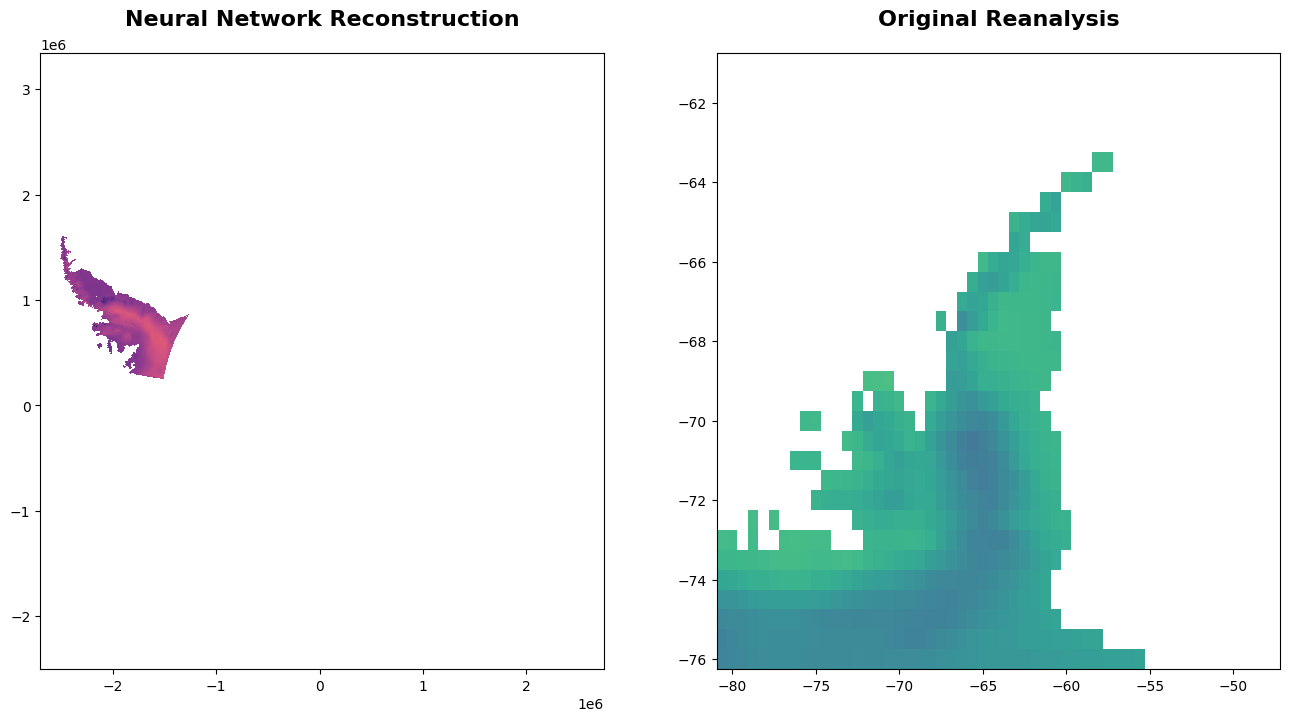

In [45]:
# Side-by-side layout for better comparison

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

fig2 = plt.figure(figsize=(16, 8))
ax1 = fig2.add_subplot(1, 2, 1,)


# Beautiful styling
# ax1.add_feature(cfeature.LAND, color='#f0f0f0', alpha=0.8)
# ax1.add_feature(cfeature.OCEAN, color='#e6f3ff', alpha=0.6)
# ax1.add_feature(cfeature.COASTLINE, linewidth=1.2, color='#2c3e50')
# ax1.add_feature(cfeature.LAKES, color='#e6f3ff', alpha=0.8)

# Add ice shelf boundaries if available
# ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'antarctic_ice_shelves_polys', 
#                                              '50m', facecolor='white', alpha=0.8))

blep1 = ax1.pcolormesh(ms['xs'][::2,::2], ms['ys'][::2,::2], reconstructed_array[::2,::2],
                       cmap='magma_r', vmin=240, vmax=290,
                       shading='auto', alpha=0.9)

ax1.set_title('Neural Network Reconstruction', fontsize=16, fontweight='bold', pad=20)

ax2 = fig2.add_subplot(1, 2, 2,)


# ax2.add_feature(cfeature.LAND, color='w', alpha=0.8)
# ax2.add_feature(cfeature.OCEAN, color='#e6f3ff', alpha=0.6)
# ax2.add_feature(cfeature.COASTLINE, linewidth=1.2, color='#2c3e50')
# ax2.add_feature(cfeature.LAKES, color='#e6f3ff', alpha=0.8)

tgood = np.mean(t2m[:,::-1,:], axis=2)

tgood[np.isnan(ms['alt_mask'])] = np.nan

blep2 = ax2.pcolormesh(ms['LON'].T, ms['LAT'].T, tgood.T,
                       cmap='viridis', vmin=240, vmax=290,
                       shading='auto', alpha=0.9)

ax2.set_title('Original Reanalysis', fontsize=16, fontweight='bold', pad=20)

In [178]:
for indx, hridx in enumerate(np.arange(0,24,3)):
    interpolator = scipy.interpolate.RegularGridInterpolator((ms['LAT'][:,::-1][0,:],ms['LON'][:,::-1][:,0]),np.squeeze(HR[ :,::,hridx]).T)
    hours_value = interpolator(np.column_stack((hlats[tqq],hlons[tqq])))
        


    fill_up_T = np.zeros((len(hlats[tqq]),8))
    fill_up_A = np.zeros((len(hlats[tqq]),8))


    for inds,shift in enumerate(shifts):

        alt_3d = np.repeat(ms['alt'][:,::-1,np.newaxis],max_hours,axis=2)

        thinking = t2m[:,::-1,:max_hours].copy()

        neighbors_up_T = np.roll(thinking, shift=shift[0], axis=shift[1])


        lat_vec = ms['LAT'][:,::][0,:]
        lon_vec = ms['LON'][:,::][:,0]

        spline = scipy.interpolate.RectBivariateSpline(
            lon_vec,lat_vec , np.squeeze(neighbors_up_T[:,:,hridx]), 
            kx=3, ky=3  # Linear interpolation (kx=3, ky=3 for cubic)
        )
        neighbors_up_T2M = spline.ev(hlons[tqq].flatten(),hlats[tqq].flatten())

        neighbors_up_T = np.roll(alt_3d, shift=shift[0], axis=shift[1])

        spline = scipy.interpolate.RectBivariateSpline(
            lon_vec,lat_vec , np.squeeze(neighbors_up_T[:,:,hridx]), 
            kx=3, ky=3  # Linear interpolation (kx=3, ky=3 for cubic)
        )
        neighbors_up_ALT = spline.ev(hlons[tqq].flatten(),hlats[tqq].flatten())

        fill_up_T[:,inds] = neighbors_up_T2M
        fill_up_A[:,inds] = neighbors_up_ALT


    predX = np.hstack((hours_value[:,np.newaxis], fill_up_T, fill_up_A, hs[tqq,np.newaxis]))




    predX_s = scaler.transform(predX)
    predX_t = torch.tensor(predX_s, dtype=torch.float32)
    ytorchped = model(predX_t)
    filtered_values = np.squeeze(ytorchped.detach().numpy())
    boolean_mask = np.squeeze(tqq)
    rows, cols = ms['h'].shape
    reconstructed_array = restructuring_filtered_array(filtered_values,boolean_mask,rows,cols)

    temp_recon[:,:,indx] = reconstructed_array


    interpolator2 = scipy.interpolate.RegularGridInterpolator((ms['LAT'][:,::-1][0,:],ms['LON'][:,::-1][:,0]),np.squeeze(t2m[:,::-1,hridx]).T)
    
    for locx,proper_indice in enumerate(proper_indices):
        results[threehourlyindx,locx] = reconstructed_array[proper_indice]
        weknows[threehourlyindx,locx] =  interpolator2((lat_locs[locx],lon_locs[locx]))
    

    if hridx == 0:
        fig2 = plt.figure()   
        plt.pcolormesh(reconstructed_array[:,::1],cmap='rainbow',vmin=235,vmax=290)
        plt.colorbar(label='Temperature [K]')
        plt.xlim([200,1400])
        plt.ylim([2400,4600])
        fig2.savefig(startstring + 'NN_Map_Day_'+str(j)+'.png')
        plt.close()

    threehourlyindx += 1 

temp_recon_full = np.nanmean(temp_recon,axis=2)


for locx,location in enumerate(locations['site_name'].to_numpy()): 
    print(location)
    fig = plt.figure()
    aws_file = pd.read_csv('AWS_Data/'+locations['site_name'].to_numpy()[locx]+'_3h.csv')
    day_nums  = np.arange(0,len(results[:,0]))/8.
    plt.plot(day_nums,results[:,locx],'b--',zorder=16)
    plt.plot(day_nums,weknows[:,locx],'r-',alpha=0.5,zorder=15)
    extent = len(day_nums)
    if len(aws_file['Temperature(C)'][aws_file['Year'] == year_pick]) < extent:
        extent = len(aws_file['Temperature(C)'][aws_file['Year'] == year_pick])
    plt.plot(day_nums[:extent],aws_file['Temperature(C)'][aws_file['Year'] == year_pick][:extent]+273.15,'k-')
    plt.xlim([0,threehourlyindx/8.])
    
    # difference1 = results[:,locx]-aws_file['Temperature(C)'][aws_file['Year'] == year_pick][:extent]+273.15
    # difference2 = weknows[:,locx]-aws_file['Temperature(C)'][aws_file['Year'] == year_pick][:extent]+273.15


    fig.savefig(startstring +'NN_run1_'+location+'.png')

    plt.close()





/tmp/ipykernel_3996521/151154997.py:75: RuntimeWarning: Mean of empty slice
  temp_recon_full = np.nanmean(temp_recon,axis=2)


aws14
aws15
Fossil Bluff
Butler Island
Sky Blu
Limbert
Hutton Mountains
Traverse Mountains


In [155]:
lat_vec = ms['LAT'][:,::][0,:]
lon_vec = ms['LON'][:,::][:,0]
hr_data = np.squeeze(HR[:,:,hridx])

# Create spline interpolator
spline = scipy.interpolate.RectBivariateSpline(
    lon_vec,lat_vec , hr_data, 
    kx=1, ky=1  # Linear interpolation (kx=3, ky=3 for cubic)
)

# Interpolate
hours_value = spline.ev(hlats[tqq].flatten(), hlons[tqq].flatten())


-0.17142504661796076
-0.17904551994751383
-0.9475597139007585
-0.13261865826206387
0.37687576644618415
-0.08546347710461255
-1.1232216477383608
0.4360686301432981


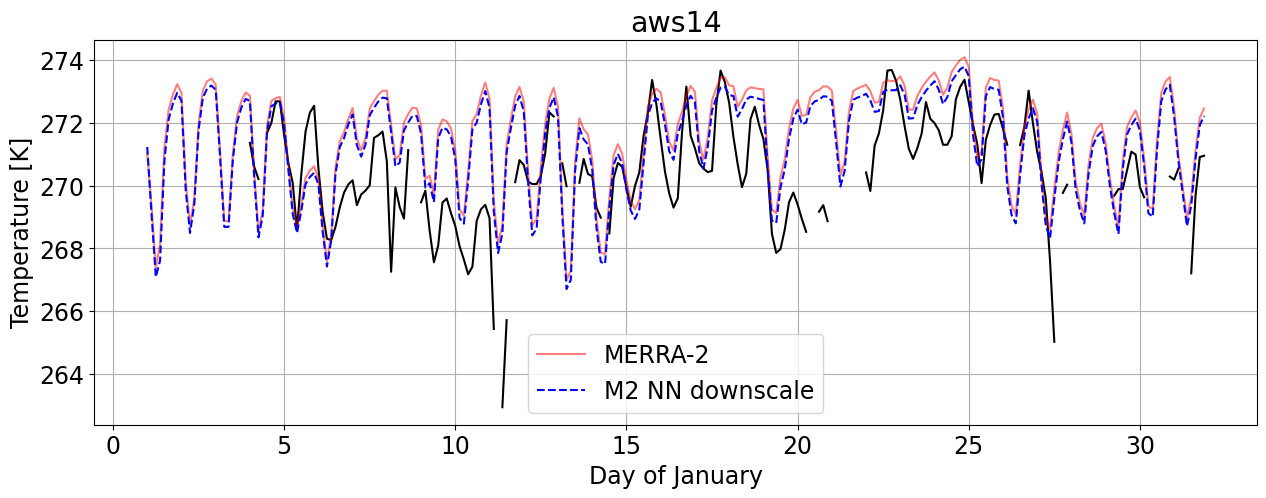

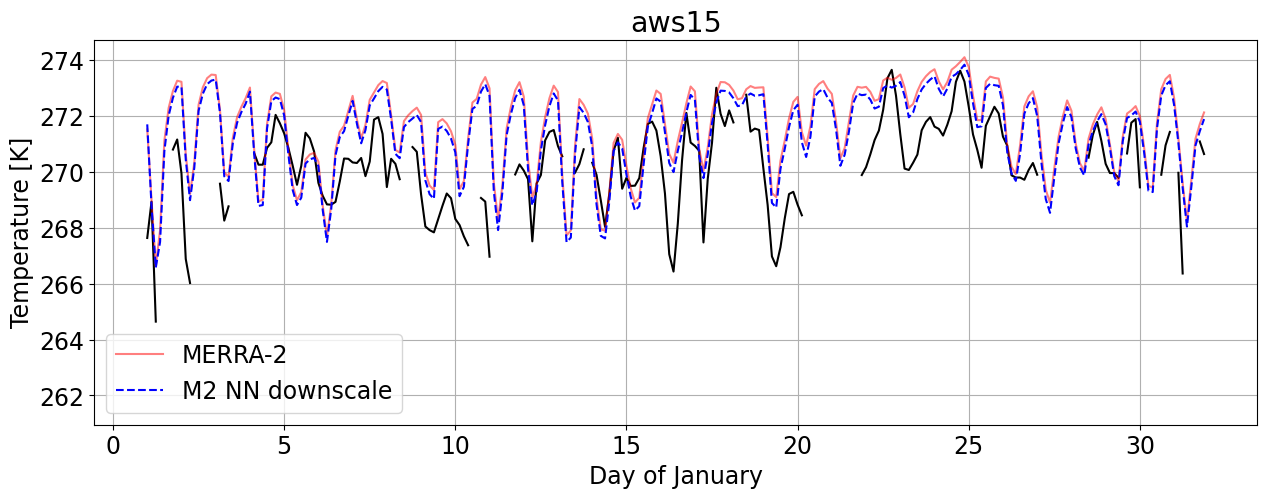

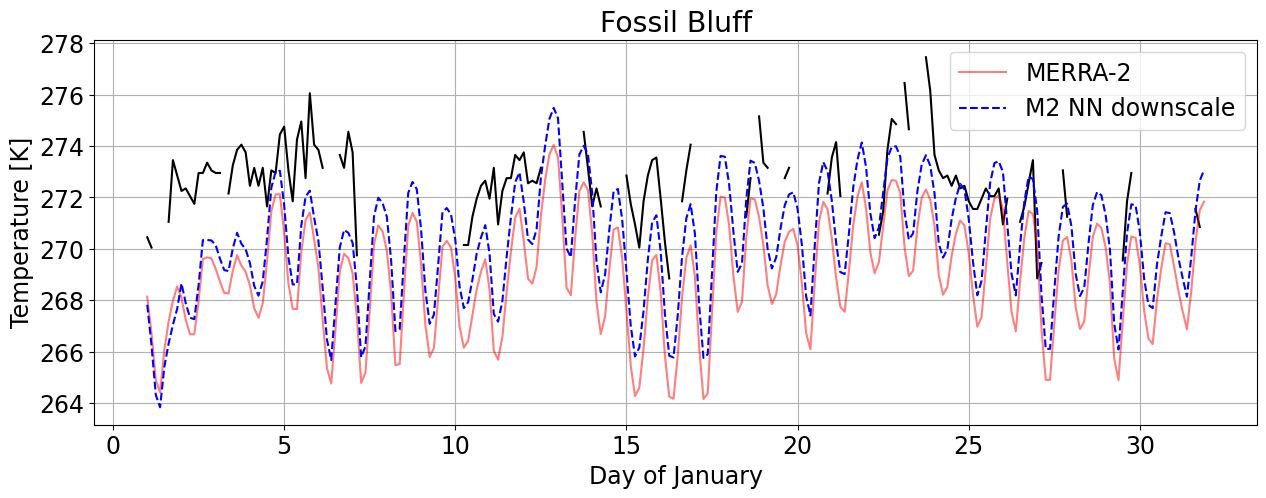

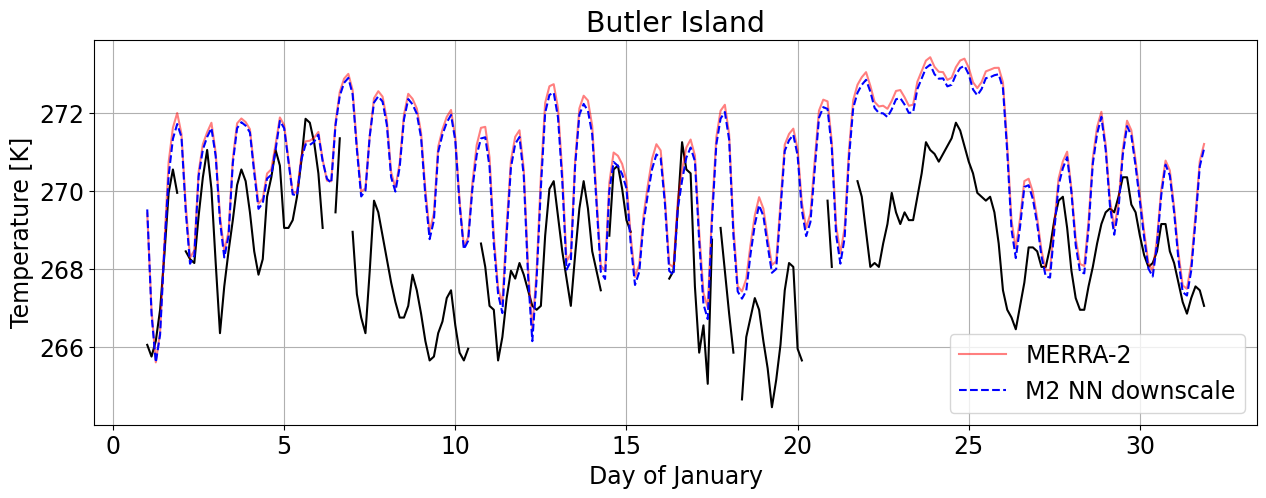

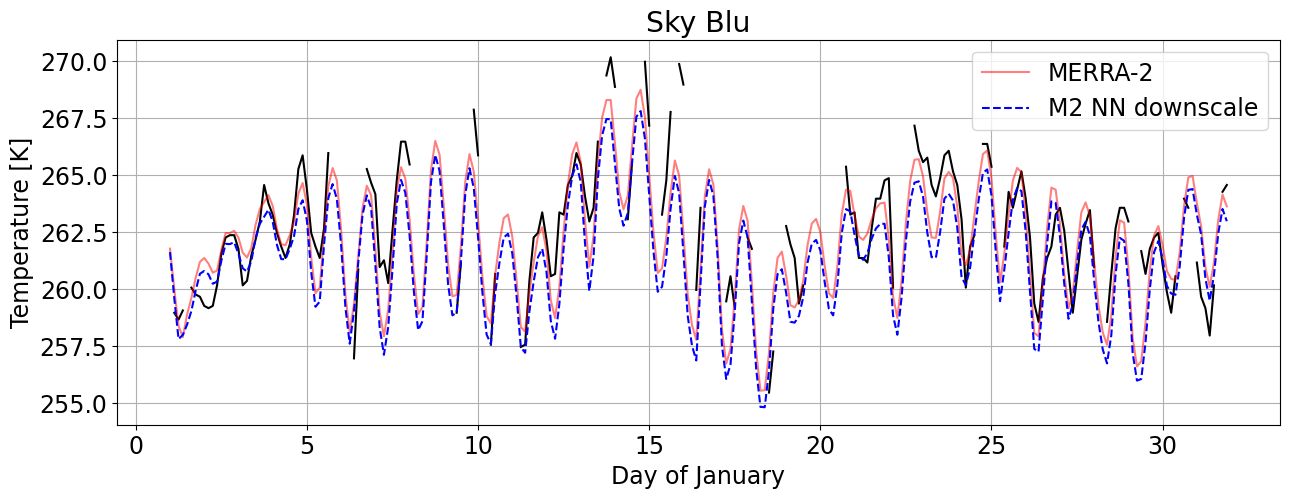

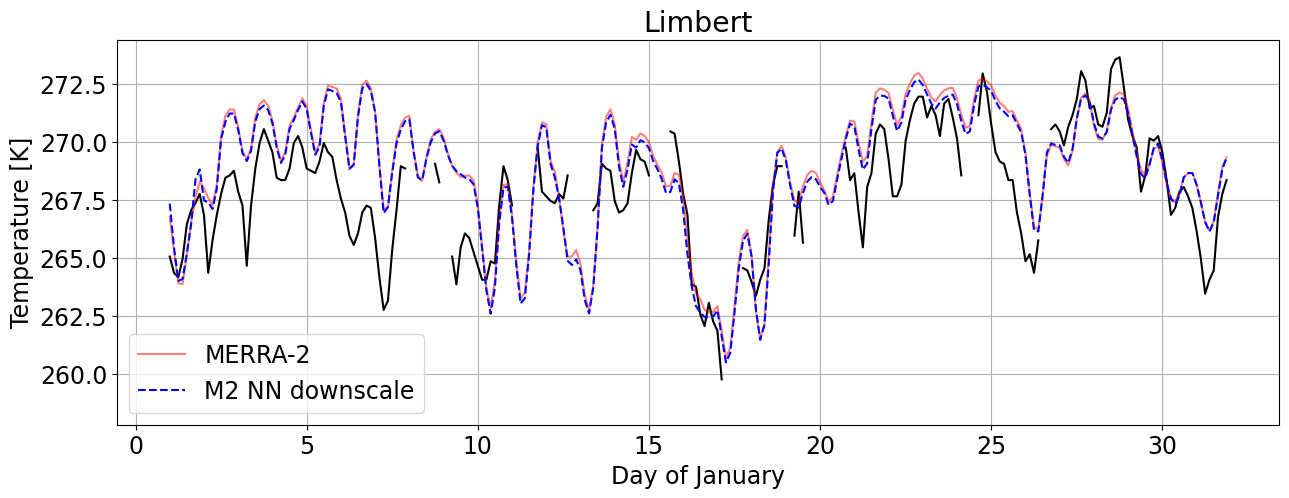

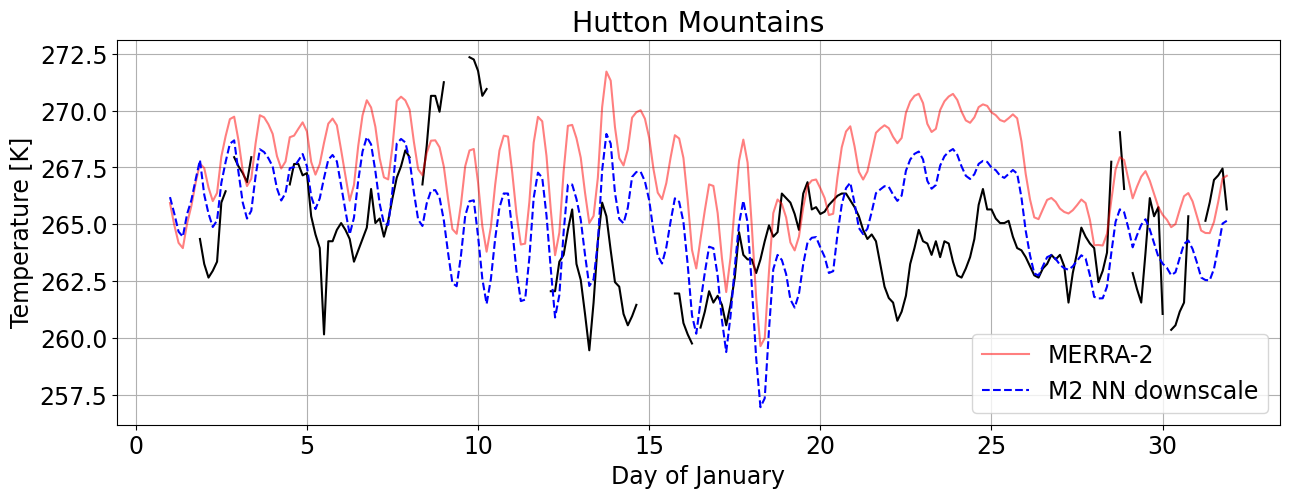

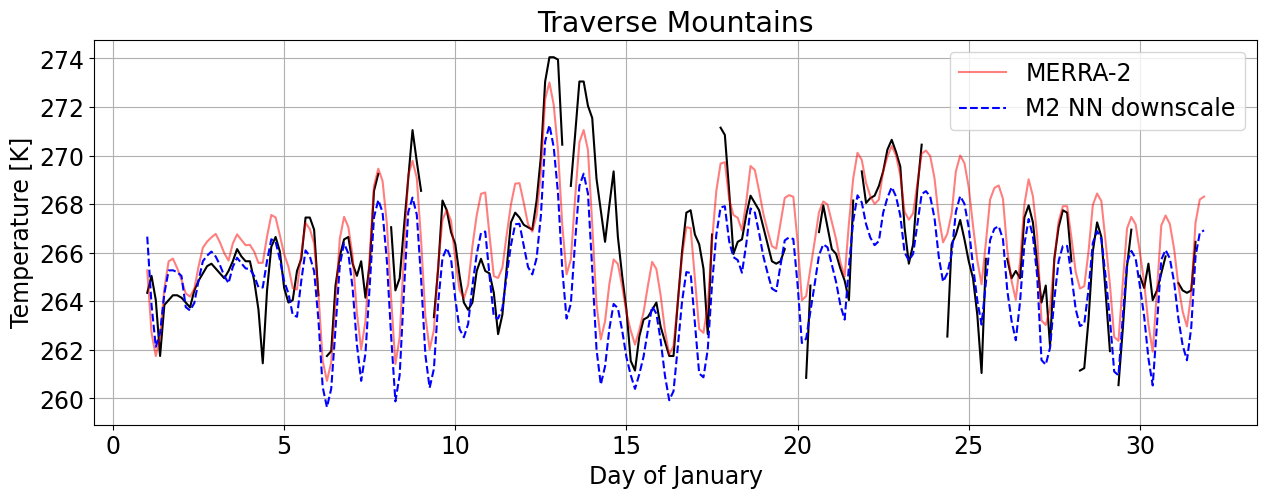

In [ ]:
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import scipy 
year_pick = 2010 

locations = pd.read_csv('Locations_File.csv')

filemat = scipy.io.loadmat('year2010_3_day_30')

weknows = filemat['weknows']
results = filemat['results']
how_long = 16

for locx,location in enumerate(locations['site_name'].to_numpy()): 
    fig = plt.figure(figsize=(15,5))
    aws_file = pd.read_csv('AWS_Data/'+locations['site_name'].to_numpy()[locx]+'_3h.csv')
    day_nums  = np.arange(0,len(results[:,0]))/8.+1
    extent = len(day_nums)
    extent2 = len(aws_file['Temperature(C)'][aws_file['Year'] == year_pick])
    extent = 31*8
    extent2 = 31*8
    obs = aws_file['Temperature(C)'][aws_file['Year'] == year_pick][:extent]+273.15
    obs_smooth = pd.DataFrame(aws_file['Temperature(C)'][aws_file['Year'] == year_pick][:extent2]+273.15)
    m2 = pd.DataFrame(weknows[:extent,locx].flatten())
    m2plus = pd.DataFrame(results[:extent,locx].flatten())
    plt.plot(day_nums[:extent2],obs_smooth[:extent2],'k-')

    goodpts = (~np.isnan(obs_smooth.to_numpy())) & (~np.isnan(m2.to_numpy()[:extent2])) & (~np.isnan(m2plus.to_numpy()[:extent2]))

    plt.plot(day_nums[:extent],m2,'r-',alpha=0.5,label='MERRA-2')
    plt.plot(day_nums[:extent],m2plus,'b--',label='M2 NN downscale')
    # plt.xlim([0,31])
    # plt.ylim([260,280])

    


    rmse_M2 = root_mean_squared_error(obs_smooth.to_numpy()[goodpts],m2.to_numpy()[:extent2][goodpts])
    rmse_m2plus = root_mean_squared_error(obs_smooth.to_numpy()[goodpts],m2plus.to_numpy()[:extent2][goodpts])

    print((rmse_m2plus-rmse_M2))

    plt.xlabel('Day of January')
    # daysofyear = np.arange(0,35,5)
    # daysofyear[0] = 1
    # plt.xticks(daysofyear)
    plt.ylabel('Temperature [K]')
    plt.grid('on')
    plt.title(location)
    plt.legend()



In [10]:
# Loading in slv data from MERRA-2 (temp, etc)
fnamesS = glob.glob('/scratch/satellite/MERRA2/M2T1NXSLV_2010/MERRA2_300.tavg*slv*n*')
nm = len(fnamesS)
dtf = []
for i in range(nm):
    dtf.append(int(fnamesS[i][-12:-4].strip('.')))
ib = np.argsort(dtf)
fnamesS = [fnamesS[i] for i in ib]

In [ ]:


proper_indices = []

lat_locs = locations['latitude']
lon_locs = locations['longitude']
max_hours = 24
nday = 31

alt = np.repeat(ms['alt'][:,::,np.newaxis],max_hours,axis=2).reshape(-1,1)
# frocean =np.repeat(ms['frocean'][:,::-1,np.newaxis],max_hours,axis=2).reshape(-1,1)
alt_mask = np.repeat(ms['alt_mask'][:,::,np.newaxis],max_hours,axis=2).reshape(-1,1)
pLat = np.repeat(ms['LAT'][:,::-1,np.newaxis],max_hours,axis=2).reshape(-1,1)
pLon = np.repeat(ms['LON'][:,::-1,np.newaxis],max_hours,axis=2).reshape(-1,1)
hlats = ms['hlat'][:,::].reshape(-1,1)
hlons = ms['hlon'][:,::].reshape(-1,1)
hs = ms['h'][:,::].reshape(-1,1)
new_alt_3d = np.repeat(ms['alt'][:,::-1,np.newaxis],max_hours,axis=2) 


# # AWS data
lat_locs = np.asarray(locations['latitude'].to_numpy(),dtype=np.float32)
lon_locs = np.asarray(locations['longitude'].to_numpy(),dtype=np.float32)

# *** OUTPUT ***
results = np.zeros((8*nday,len(lat_locs)))*np.nan # Modeled temperatures using downscaling
weknows = np.zeros((8*nday,len(lat_locs)))*np.nan # 


import glob

temps_small = np.zeros((i4-i3+1,i1-i2+1))

threehourlyindx = 0 # index of 3 hourly output 

for j in range(nday):
    print(j)
    nme = fnamesS[j]
    ds = nc.Dataset(nme)
    t2m = ds.variables['T2M'][:,i2:i1+1, i3:i4+1].transpose(2, 1, 0)
    t2m = np.copy(t2m[:,::-1,:]) # flipping because t2m is backwards relative to everything else
    good_temp = np.mean(t2m,axis=2)
    temps_small = temps_small + (good_temp)/31.

    del good_temp, t2m, ds
    

In [ ]:

filemat = scipy.io.loadmat('year2010_3_day_1.mat')
total_size =  np.zeros((filemat['fullsizerecon'].shape[0], filemat['fullsizerecon'].shape[1]))
del filemat 
for j in range(0,31):
    print(j)
    filemat2 = scipy.io.loadmat('year2010_3_day_'+str(j)+'.mat')
    total_size = filemat2['fullsizerecon']/31. + total_size

    del filemat2


good_temperatures = total_size



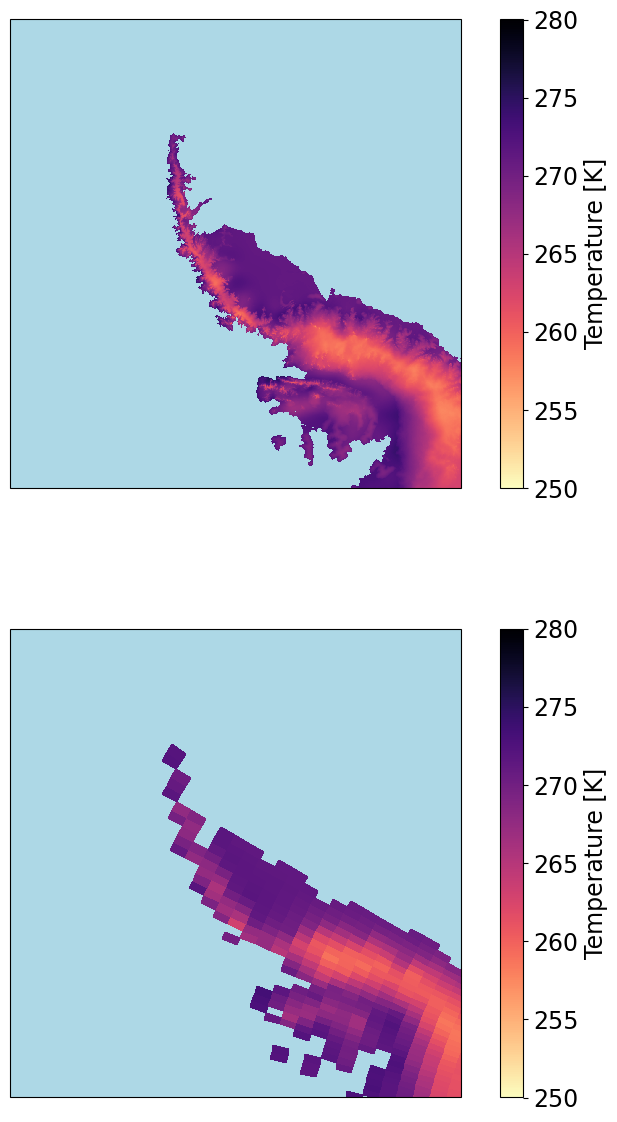

In [85]:
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature

fig2 = plt.figure(figsize=(10, 14))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.3)

ax1 = fig2.add_subplot(gs[0],projection=projection)  # Top subplot (2x height)
ax1.set_facecolor('lightblue')

blep=ax1.pcolormesh(ms['xs'],ms['ys'],good_temperatures,cmap='magma_r',vmin=250,vmax=280)
plt.colorbar(blep,ax=ax1,label='Temperature [K]')


# Add basic map features
# ax1.add_feature(cfeature.LAND, color='white')

# Add ice features from Natural Earth
antarctic_ice = NaturalEarthFeature(
    category='physical',
    name='antarctic_ice_shelves_polys',
    scale='50m',
    facecolor='white',
    alpha=0.9
)
# ax1.add_feature(antarctic_ice,zorder=-1)

ax1.set_extent([-78, -50, -72, -62], ccrs.PlateCarree())


# tgood[np.isnan(ms['alt_mask'][:,::-1])] = np.nan

# blep2 = ax2.pcolormesh(ms['LAT'],ms['LON'],temps_small,cmap='magma_r',vmin=250,vmax=280)
# plt.colorbar(blep2,ax=ax2,label='Temperature [K]')
# ax2.set_ylabel('Longitude ')
# ax2.set_xlabel('Latitude ')

# fig2.savefig(startstring + 'Janaury_File'+str(j)+'.png')

ax2 = fig2.add_subplot(gs[1],projection=projection)  # Top subplot (2x height)
ax2.set_facecolor('lightblue')

ax2.add_feature(cfeature.OCEAN, color='lightblue')
# ax2.add_feature(cfeature.LAND, color='w')

# Add ice features from Natural Earth
antarctic_ice = NaturalEarthFeature(
    category='physical',
    name='antarctic_ice_shelves_polys',
    scale='50m',
    facecolor='white',
    alpha=0.9
)
# ax2.add_feature(antarctic_ice,zorder=-1)

temps_small2 = temps_small.copy()

temps_small2[np.isnan(ms['alt_mask'][:,::-1])] = np.nan

blob = ax2.pcolormesh(ms['LON'][:,::],ms['LAT'][:,::-1],temps_small2,transform=ccrs.PlateCarree(),vmin=250,vmax=280,cmap='magma_r')

ax2.set_extent([-78, -50, -72, -62], ccrs.PlateCarree())

plt.colorbar(blob,ax=ax2,label='Temperature [K]')

plt.savefig('January_Value_etc.png',dpi=300)